In [3]:
# Set seed for reproducibility
SEED = 42

import os
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import random
import numpy as np
np.random.seed(SEED)
random.seed(SEED)

import torch
torch.manual_seed(SEED)
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
else:
    device = torch.device("cpu")

import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

PyTorch version: 2.8.0+cu126
Device: cuda


In [4]:
# Load and preprocess data
df = pd.read_csv("pirate_pain_train.csv")
target = pd.read_csv("pirate_pain_train_labels.csv")

# Encode categorical features
number_cols = ['n_legs', 'n_hands', 'n_eyes']
for col in number_cols:
    df[col] = df[col].astype('category').cat.codes

# Normalize joint columns
joint_cols = ["joint_" + str(i).zfill(2) for i in range(31)]
for col in joint_cols:
    df[col] = df[col].astype(np.float32)

minmax_scaler = MinMaxScaler()
df[joint_cols] = minmax_scaler.fit_transform(df[joint_cols])

data_cols = number_cols + joint_cols

# Map labels
label_mapping = {'no_pain': 0, 'low_pain': 1, 'high_pain': 2}
target['label'] = target['label'].map(label_mapping)

print("Data loaded and preprocessed")
print(f"Features: {len(data_cols)}")
print(f"Samples: {len(df['sample_index'].unique())}")
print(f"\nClass distribution:")
print(target['label'].value_counts().sort_index())

Data loaded and preprocessed
Features: 34
Samples: 661

Class distribution:
label
0    511
1     94
2     56
Name: count, dtype: int64


In [5]:
# ⭐ IMPROVED: Stratified split at USER level
# Create user-label mapping (one label per user)
user_labels = target.groupby('sample_index')['label'].first()

print("\nUser-level class distribution:")
print(user_labels.value_counts().sort_index())

# Stratified split to ensure both train and val have similar class distributions
train_users, val_users = train_test_split(
    user_labels.index,
    test_size=0.2,
    random_state=SEED,
    stratify=user_labels.values  # ← KEY IMPROVEMENT
)

print(f"\nTrain users: {len(train_users)}")
print(f"Val users: {len(val_users)}")
print("\nTrain user class distribution:")
print(user_labels[train_users].value_counts().sort_index())
print("\nVal user class distribution:")
print(user_labels[val_users].value_counts().sort_index())


User-level class distribution:
label
0    511
1     94
2     56
Name: count, dtype: int64

Train users: 528
Val users: 133

Train user class distribution:
label
0    408
1     75
2     45
Name: count, dtype: int64

Val user class distribution:
label
0    103
1     19
2     11
Name: count, dtype: int64


In [6]:
# Build sequences with LARGER STRIDE to reduce temporal leakage
WINDOW_SIZE = 600
STRIDE = 200  # ⭐ IMPROVED: 50% overlap instead of 83%

def build_sequences(df, target_df, window=300, stride=150):
    dataset = []
    labels = []

    for id in df['sample_index'].unique():
        temp = df[df['sample_index'] == id][data_cols].values
        label = target_df[target_df['sample_index'] == id]['label'].values[0]

        padding_len = window - len(temp) % window
        padding = np.zeros((padding_len, len(data_cols)), dtype='float32')
        temp = np.concatenate((temp, padding))

        idx = 0
        while idx + window <= len(temp):
            dataset.append(temp[idx:idx + window])
            labels.append(label)
            idx += stride

    return np.array(dataset), np.array(labels)

df_train = df[df['sample_index'].isin(train_users)]
df_val = df[df['sample_index'].isin(val_users)]

print(df.shape)

X_train, y_train = build_sequences(df_train, target, WINDOW_SIZE, STRIDE)
X_val, y_val = build_sequences(df_val, target, WINDOW_SIZE, STRIDE)

print(f"\nTraining sequences: {X_train.shape}")
print(f"Validation sequences: {X_val.shape}")

train_counts = np.bincount(y_train.astype(int))
val_counts = np.bincount(y_val.astype(int))

print(f"\nTrain sequence distribution:")
for cls, count in enumerate(train_counts):
    print(f"  Class {cls}: {count} ({count/len(y_train)*100:.1f}%)")

print(f"\nVal sequence distribution:")
for cls, count in enumerate(val_counts):
    print(f"  Class {cls}: {count} ({count/len(y_val)*100:.1f}%)")

(105760, 40)

Training sequences: (528, 600, 34)
Validation sequences: (133, 600, 34)

Train sequence distribution:
  Class 0: 408 (77.3%)
  Class 1: 75 (14.2%)
  Class 2: 45 (8.5%)

Val sequence distribution:
  Class 0: 103 (77.4%)
  Class 1: 19 (14.3%)
  Class 2: 11 (8.3%)


In [7]:
# Direct oversampling to balance dataset
target_count = train_counts[0]
duplication_factors = np.ceil(target_count / train_counts).astype(int)

X_train_balanced = []
y_train_balanced = []

for cls in range(len(train_counts)):
    cls_indices = np.where(y_train == cls)[0]
    for _ in range(duplication_factors[cls]):
        X_train_balanced.append(X_train[cls_indices])
        y_train_balanced.append(y_train[cls_indices])

X_train_balanced = np.concatenate(X_train_balanced, axis=0)
y_train_balanced = np.concatenate(y_train_balanced, axis=0)

# Shuffle balanced dataset
shuffle_idx = np.random.permutation(len(X_train_balanced))
X_train_balanced = X_train_balanced[shuffle_idx]
y_train_balanced = y_train_balanced[shuffle_idx]

balanced_counts = np.bincount(y_train_balanced.astype(int))
print("Balanced distribution:", balanced_counts)
print(f"Total training samples: {len(y_train_balanced)}")

Balanced distribution: [408 450 450]
Total training samples: 1308


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class YourModel(nn.Module):
    """
    BiLSTM + Bahdanau-style Attention per time-series classification.

    Input:  x  -> (batch_size, seq_len, input_size)
    Output: logits -> (batch_size, num_classes)
    """
    def __init__(
        self,
        input_size,
        num_classes,
        hidden_size=128,
        num_layers=2,
        dropout_rate=0.3,
        **kwargs
    ):
        super().__init__()

        self.input_size = input_size
        self.num_classes = num_classes
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout_rate = dropout_rate

        # -----------------------
        # 1) BiLSTM stack
        # -----------------------
        # batch_first=True → (B, T, F)
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout_rate if num_layers > 1 else 0.0,
        )

        # Dimensione dell'output LSTM: hidden_size * 2 (fw + bw)
        lstm_out_dim = hidden_size * 2

        # -----------------------
        # 2) Bahdanau-style Attention
        # -----------------------
        # score_t = v^T * tanh(W_h * h_t)
        self.attn_W = nn.Linear(lstm_out_dim, lstm_out_dim, bias=True)
        self.attn_v = nn.Linear(lstm_out_dim, 1, bias=False)

        # -----------------------
        # 3) Classification head
        # -----------------------
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Sequential(
            nn.Linear(lstm_out_dim, lstm_out_dim // 2),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(lstm_out_dim // 2, num_classes),
        )

    def attention(self, lstm_out):
        """
        lstm_out: (B, T, H*2)
        ritorna:
            context: (B, H*2)
            attn_weights: (B, T)
        """
        # u_t = tanh(W_h * h_t)
        # lstm_out: (B, T, D)
        u = torch.tanh(self.attn_W(lstm_out))      # (B, T, D)

        # score_t = v^T u_t
        scores = self.attn_v(u).squeeze(-1)       # (B, T)

        # α_t = softmax(scores)
        attn_weights = F.softmax(scores, dim=-1)  # (B, T)

        # context = Σ_t α_t * h_t
        # (B, 1, T) @ (B, T, D) -> (B, 1, D) -> (B, D)
        context = torch.bmm(attn_weights.unsqueeze(1), lstm_out).squeeze(1)
        return context, attn_weights

    def forward(self, x):
        """
        x: (batch_size, seq_len, input_size)
        """
        # 1) BiLSTM
        # lstm_out: (B, T, 2*H)
        lstm_out, _ = self.lstm(x)

        # 2) Attention pooling sui time-step
        context, attn_weights = self.attention(lstm_out)  # (B, 2H), (B, T)

        # 3) Classificazione
        context = self.dropout(context)
        logits = self.classifier(context)  # (B, num_classes)

        return logits

model = YourModel(
    input_size=34,
    num_classes=3,
    hidden_size=128,
    num_layers=2,
    dropout_rate=0.3
).to(device)


In [13]:
# Create dataloaders
BATCH_SIZE = 16

train_ds = TensorDataset(torch.from_numpy(X_train_balanced).float(), torch.from_numpy(y_train_balanced).long())
val_ds = TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

Train batches: 82
Val batches: 9


In [14]:
# Training setup with STRONGER regularization
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-4,
    weight_decay=1e-3  # ⭐ IMPROVED: 1e-3 instead of 1e-4
)
scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

def train_epoch(model, loader, criterion, optimizer, scaler, device):
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        # Check for NaN/inf loss *before* backward pass
        if not torch.isfinite(loss):
            print(f"Warning: Non-finite loss encountered (NaN/Inf). Skipping backward pass and optimizer step for this batch.")
            continue

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item() * inputs.size(0)
        all_preds.extend(outputs.argmax(1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(loader.dataset)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    return avg_loss, f1

def val_epoch(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)

            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            total_loss += loss.item() * inputs.size(0)
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(loader.dataset)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    return avg_loss, f1, all_preds, all_labels

print("Training functions ready")

Training functions ready


In [15]:
# Train with early stopping
print("=" * 80)
print("Training IMPROVED CNN Model with Stratified Split")
print("=" * 80)

EPOCHS = 1000
best_val_f1 = 0.0 # Changed to track best F1
best_val_loss_at_best_f1 = float('inf') # Store loss corresponding to best F1
patience = 100
patience_counter = 0
best_epoch = 0 # To log which epoch had the best F1

# Initialize training_history dictionary
training_history = {
    'train_loss': [],
    'val_loss': [],
    'train_f1': [],
    'val_f1': []
}

for epoch in range(1, EPOCHS + 1):
    train_loss, train_f1 = train_epoch(model, train_loader, criterion, optimizer, scaler, device)
    val_loss, val_f1, val_preds, val_labels = val_epoch(model, val_loader, criterion, device)

    # Append current epoch's metrics to history
    training_history['train_loss'].append(train_loss)
    training_history['val_loss'].append(val_loss)
    training_history['train_f1'].append(train_f1)
    training_history['val_f1'].append(val_f1)

    # Check if val_loss is NaN
    is_val_loss_nan = torch.isnan(torch.tensor(val_loss))

    if not is_val_loss_nan and val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_val_loss_at_best_f1 = val_loss
        patience_counter = 0
        best_epoch = epoch
        torch.save(model.state_dict(), 'cnn_improved_best.pt')
        print(f"Epoch {epoch:3d}/{EPOCHS} | Train: Loss={train_loss:.4f}, F1={train_f1:.4f} | Val: Loss={val_loss:.4f}, F1={val_f1:.4f} ⭐ BEST F1")
    else:
        patience_counter += 1
        if epoch % 5 == 0 or epoch == 1:
            val_loss_str = f"{val_loss:.4f}" if not is_val_loss_nan else "NaN"
            print(f"Epoch {epoch:3d}/{EPOCHS} | Train: Loss={train_loss:.4f}, F1={train_f1:.4f} | Val: Loss={val_loss_str}, F1={val_f1:.4f}")

    # Early stopping
    if patience_counter >= patience:
        print(f"\nEarly stopping at epoch {epoch} (no improvement in F1 or NaN loss for {patience} epochs)")
        break

print("\n" + "=" * 80)
print(f"Best validation F1: {best_val_f1:.4f} (from epoch {best_epoch}, loss={best_val_loss_at_best_f1:.4f})")
print("=" * 80)


Training IMPROVED CNN Model with Stratified Split
Epoch   1/1000 | Train: Loss=1.1002, F1=0.2198 | Val: Loss=1.1047, F1=0.0126 ⭐ BEST F1
Epoch   3/1000 | Train: Loss=1.0971, F1=0.3009 | Val: Loss=1.1328, F1=0.0388 ⭐ BEST F1
Epoch   4/1000 | Train: Loss=1.0924, F1=0.2990 | Val: Loss=1.1831, F1=0.0459 ⭐ BEST F1
Epoch   5/1000 | Train: Loss=1.0749, F1=0.3178 | Val: Loss=1.1548, F1=0.0473 ⭐ BEST F1
Epoch   6/1000 | Train: Loss=0.9865, F1=0.4579 | Val: Loss=1.3732, F1=0.4645 ⭐ BEST F1
Epoch   7/1000 | Train: Loss=0.9154, F1=0.5526 | Val: Loss=1.0638, F1=0.6876 ⭐ BEST F1
Epoch   8/1000 | Train: Loss=0.8424, F1=0.6294 | Val: Loss=1.0484, F1=0.6901 ⭐ BEST F1
Epoch  10/1000 | Train: Loss=0.7908, F1=0.6609 | Val: Loss=0.8533, F1=0.7645 ⭐ BEST F1
Epoch  14/1000 | Train: Loss=0.6360, F1=0.7999 | Val: Loss=0.7267, F1=0.7763 ⭐ BEST F1
Epoch  15/1000 | Train: Loss=0.6016, F1=0.7986 | Val: Loss=0.7937, F1=0.7768 ⭐ BEST F1
Epoch  17/1000 | Train: Loss=0.5729, F1=0.8140 | Val: Loss=0.6528, F1=0.8054 ⭐ B

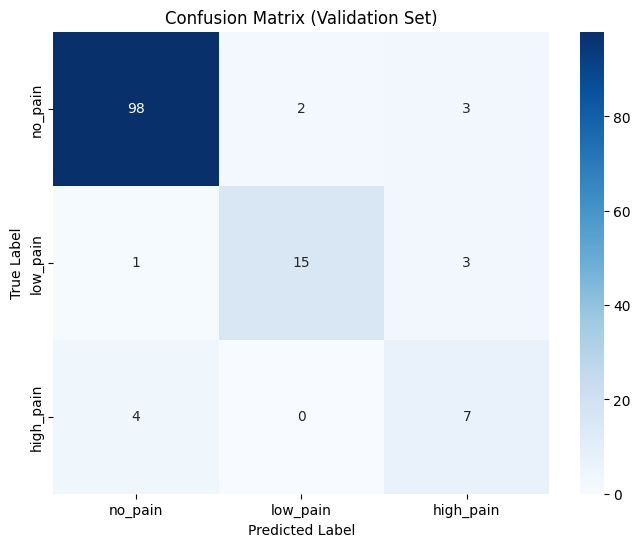

In [16]:
# @title Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions for the validation set
model.eval()
val_predictions = []
val_targets = []
with torch.no_grad():
    for inputs, targets in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        val_predictions.extend(predicted.cpu().numpy())
        val_targets.extend(targets.cpu().numpy())

# Calculate the confusion matrix
cm = confusion_matrix(val_targets, val_predictions)

# Define class labels
class_labels = ['no_pain', 'low_pain', 'high_pain']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Validation Set)')
plt.show()

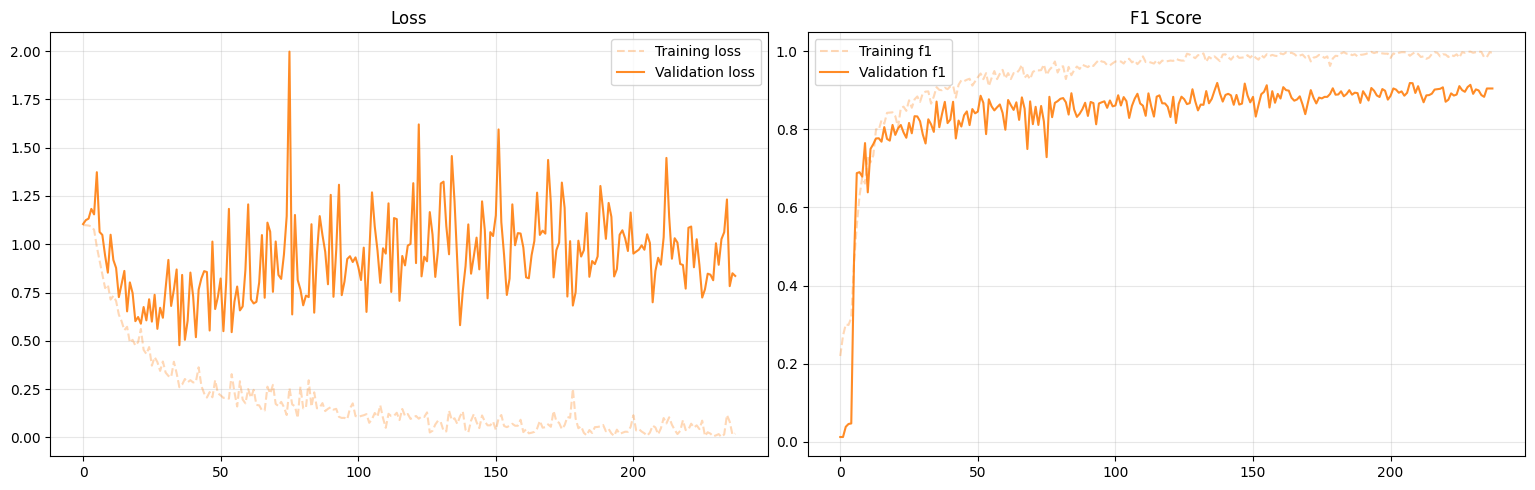

In [17]:
# @title Plot History

# Create a figure with two side-by-side subplots (two columns)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# Plot of training and validation loss on the first axis
ax1.plot(training_history['train_loss'], label='Training loss', alpha=0.3, color='#ff7f0e', linestyle='--')
ax1.plot(training_history['val_loss'], label='Validation loss', alpha=0.9, color='#ff7f0e')
ax1.set_title('Loss')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot of training and validation accuracy on the second axis
ax2.plot(training_history['train_f1'], label='Training f1', alpha=0.3, color='#ff7f0e', linestyle='--')
ax2.plot(training_history['val_f1'], label='Validation f1', alpha=0.9, color='#ff7f0e')
ax2.set_title('F1 Score')
ax2.legend()
ax2.grid(alpha=0.3)

# Adjust the layout and display the plot
plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()

In [18]:
# Final evaluation
model.load_state_dict(torch.load('cnn_improved_best.pt'))
_, val_f1, val_preds, val_labels = val_epoch(model, val_loader, criterion, device)

print("\n" + "=" * 80)
print("📊 FINAL RESULTS (IMPROVED CNN with Stratified Split)")
print("=" * 80)
print(f"Validation F1: {val_f1:.4f}")

print("\n📋 Per-class metrics:")
print(classification_report(val_labels, val_preds, target_names=['no_pain', 'low_pain', 'high_pain'], digits=4))

print("\n📈 Confusion Matrix:")
cm = confusion_matrix(val_labels, val_preds)
print(cm)

unique_preds, counts = np.unique(val_preds, return_counts=True)
print("\n🎯 Prediction distribution:")
for cls, count in zip(unique_preds, counts):
    print(f"  Class {cls}: {count} predictions ({count/len(val_preds)*100:.1f}%)")

if len(unique_preds) >= 3:
    print("\n✅ SUCCESS: Model predicts ALL 3 classes!")
    print("\n💡 Key improvements:")
    print("   - Stratified split ensures fair validation")
    print("   - Larger stride reduces temporal leakage")
    print("   - Stronger regularization prevents overfitting")
elif len(unique_preds) == 2:
    print("\n⚠️  PARTIAL: Predicts 2 out of 3 classes")
else:
    print("\n❌ FAILED: Stuck on 1 class")


📊 FINAL RESULTS (IMPROVED CNN with Stratified Split)
Validation F1: 0.9184

📋 Per-class metrics:
              precision    recall  f1-score   support

     no_pain     0.9519    0.9612    0.9565       103
    low_pain     0.9375    0.7895    0.8571        19
   high_pain     0.6154    0.7273    0.6667        11

    accuracy                         0.9173       133
   macro avg     0.8349    0.8260    0.8268       133
weighted avg     0.9220    0.9173    0.9184       133


📈 Confusion Matrix:
[[99  1  3]
 [ 2 15  2]
 [ 3  0  8]]

🎯 Prediction distribution:
  Class 0: 104 predictions (78.2%)
  Class 1: 16 predictions (12.0%)
  Class 2: 13 predictions (9.8%)

✅ SUCCESS: Model predicts ALL 3 classes!

💡 Key improvements:
   - Stratified split ensures fair validation
   - Larger stride reduces temporal leakage
   - Stronger regularization prevents overfitting


In [19]:
import pandas as pd
from preprocessing import run_test_preprocessing

test_df = run_test_preprocessing()
test_df = build_windows(test_df, None, WINDOW_SIZE, STRIDE, feature="3d")[0]
X_test = test_df.astype(np.float32)
test_loader = make_loader(
    TensorDataset(torch.from_numpy(X_test).float()),
    batch_size=32,
    shuffle=False,
    drop_last=False
)

all_preds = []
all_probs = []

model.eval()
predictions = []
with torch.no_grad():
    for xb in test_loader:
        xb = xb[0].to(device)
        outputs = model(xb)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())
from datetime import datetime

#Re-map prediction indexes to the labels
predicted_pains = []
for pred in predictions:
  if pred == 0:
    predicted_pains.append("no_pain")
  elif pred == 1:
    predicted_pains.append("low_pain")
  else:
    predicted_pains.append("high_pain")

predictions_csv = pd.DataFrame({'sample_index': np.arange(len(test_df)), 'label': predicted_pains})
today_date = 'predictions_' + datetime.now().strftime("%Y%m%d_%H%M") + '.csv'
predictions_csv.to_csv(today_date, index=False)

ModuleNotFoundError: No module named 'preprocessing'